<h1> Machine Learning Model training and serving </h1>

The training architecture involves collecting data from the two sources, mashing them up with Dataflow and saving the results in BigQuery. That data is used for ML training in Cloud ML.  Then, the trained model is used to orchestrate windmills.

<img src="training_arch.png" />

In [1]:
%projects set ml-autoawesome

In [2]:
import os
PROJECT = 'ml-autoawesome'    # CHANGE THIS
BUCKET = 'ml-autoawesome-cmle'  # CHANGE THIS
REGION = 'us-central1' # CHANGE THIS

os.environ['PROJECT'] = PROJECT # for bash
os.environ['BUCKET'] = BUCKET # for bash
os.environ['REGION'] = REGION # for bash

In [3]:
%bash
echo "project=$PROJECT"
echo "bucket=$BUCKET"
echo "region=$REGION"
gcloud config set project $PROJECT
gcloud config set compute/region $REGION
#gcloud beta ml init-project -q

project=ml-autoawesome
bucket=ml-autoawesome-cmle
region=us-central1


Updated property [core/project].
Updated property [compute/region].


<h2> Step 1:  Import Python packages that we need </h2>

In [3]:
import tensorflow as tf
import google.datalab.ml as ml
import apache_beam as beam
from tensorflow.python.lib.io import file_io
import json
import shutil

In [5]:
INDIR = '.'
OUTDIR = '.'
os.environ['OUTDIR'] = OUTDIR

<h2> 2. Preprocessing </h2>

Align the radar and windmill data temporally and compute moving averages.

In [ ]:
def make_preprocessing_fn():
  # stop-gap ...
  def _scalar_to_vector(scalar):
    # FeatureColumns expect shape (batch_size, 1), not just (batch_size)
    return api.map(lambda x: tf.expand_dims(x, -1), scalar)
  
  def preprocessing_fn(inputs):
    result = {col: _scalar_to_vector(inputs[col]) for col in CSV_COLUMNS}
    for name in SCALE_COLUMNS:
      result[name] = _scalar_to_vector(mappers.scale_to_0_1(inputs[name]))
    return result

  return preprocessing_fn

def make_input_schema(mode):
  input_schema = {}
  if mode != tf.contrib.learn.ModeKeys.INFER:
      input_schema[LABEL_COLUMN] = tf.FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0)
  for name in ['dayofweek', 'key']:
      input_schema[name] = tf.FixedLenFeature(shape=[], dtype=tf.string, default_value='null')
  for name in ['hourofday']:
      input_schema[name] = tf.FixedLenFeature(shape=[], dtype=tf.int64, default_value=0)
  for name in SCALE_COLUMNS:
      input_schema[name] = tf.FixedLenFeature(shape=[], dtype=tf.float32, default_value=0.0)
      
  input_schema = dataset_schema.from_feature_spec(input_schema)
  return input_schema

def make_coder(schema, mode):
  import copy
  column_names = copy.deepcopy(CSV_COLUMNS)
  if mode == tf.contrib.learn.ModeKeys.INFER:
    column_names.pop(LABEL_COLUMN)
  coder = coders.CsvCoder(column_names, schema)
  return coder

def preprocess_all(pipeline, training_data, eval_data, predict_data, output_dir, mode=tf.contrib.learn.ModeKeys.TRAIN):
  path_constants = PathConstants()
  work_dir = os.path.join(output_dir, path_constants.TEMP_DIR)
  
  # create schema
  input_schema = make_input_schema(mode)

  # coder
  coder = make_coder(input_schema, mode)

  # 3) Read from text using the coder.
  train_data = (
      pipeline
      | 'ReadTrainingData' >> beam.io.ReadFromText(training_data)
      | 'ParseTrainingCsv' >> beam.Map(coder.decode))

  evaluate_data = (
      pipeline
      | 'ReadEvalData' >> beam.io.ReadFromText(eval_data)
      | 'ParseEvalCsv' >> beam.Map(coder.decode))

  # metadata
  input_metadata = dataset_metadata.DatasetMetadata(schema=input_schema)

  _ = (input_metadata
       | 'WriteInputMetadata' >> io.WriteMetadata(
           os.path.join(output_dir, path_constants.RAW_METADATA_DIR),
           pipeline=pipeline))

  preprocessing_fn = make_preprocessing_fn()
  (train_dataset, train_metadata), transform_fn = (
      (train_data, input_metadata)
      | 'AnalyzeAndTransform' >> tft.AnalyzeAndTransformDataset(
          preprocessing_fn, work_dir))

  # WriteTransformFn writes transform_fn and metadata to fixed subdirectories
  # of output_dir, which are given by path_constants.TRANSFORM_FN_DIR and
  # path_constants.TRANSFORMED_METADATA_DIR.
  transform_fn_is_written = (transform_fn | io.WriteTransformFn(output_dir))

  (evaluate_dataset, evaluate_metadata) = (
      ((evaluate_data, input_metadata), transform_fn)
      | 'TransformEval' >> tft.TransformDataset())

  train_coder = coders.ExampleProtoCoder(train_metadata.schema)
  _ = (train_dataset
       | 'SerializeTrainExamples' >> beam.Map(train_coder.encode)
       | 'WriteTraining'
       >> beam.io.WriteToTFRecord(
           os.path.join(output_dir,
                        path_constants.TRANSFORMED_TRAIN_DATA_FILE_PREFIX),
           file_name_suffix='.tfrecord.gz'))

  evaluate_coder = coders.ExampleProtoCoder(evaluate_metadata.schema)
  _ = (evaluate_dataset
       | 'SerializeEvalExamples' >> beam.Map(evaluate_coder.encode)
       | 'WriteEval'
       >> beam.io.WriteToTFRecord(
           os.path.join(output_dir,
                        path_constants.TRANSFORMED_EVAL_DATA_FILE_PREFIX),
           file_name_suffix='.tfrecord.gz'))

  if predict_data:
    predict_mode = tf.contrib.learn.ModeKeys.INFER
    predict_schema = make_input_schema(mode=predict_mode)
    tsv_coder = make_coder(predict_schema, mode=predict_mode)
    predict_coder = coders.ExampleProtoCoder(predict_schema)
    _ = (pipeline
         | 'ReadPredictData' >> beam.io.ReadFromText(predict_data,
                                                     coder=tsv_coder)
         # TODO(b/35194257) Obviate the need for this explicit serialization.
         | 'EncodePredictData' >> beam.Map(predict_coder.encode)
         | 'WritePredictData' >> beam.io.WriteToTFRecord(
             os.path.join(output_dir,
                          path_constants.TRANSFORMED_PREDICT_DATA_FILE_PREFIX),
             file_name_suffix='.tfrecord.gz'))

  # Workaround b/35366670, to ensure that training and eval don't start before
  # the transform_fn is written.
  train_dataset |= beam.Map(
      lambda x, y: x, y=beam.pvalue.AsSingleton(transform_fn_is_written))
  evaluate_dataset |= beam.Map(
      lambda x, y: x, y=beam.pvalue.AsSingleton(transform_fn_is_written))

  return transform_fn, train_dataset, evaluate_dataset

p = beam.Pipeline()
output_dataset = 'windmills_control'
transform_fn, train_dataset, eval_dataset = preprocess_all(
      p, train_data_paths, eval_data_paths, predict_data_paths, output_dataset)

p.run()

In [ ]:
import pandas as pd
import numpy as np
import datalab.bigquery as bq

# get data from BigQuery
query="""
SELECT
  speed, weight, angular_momentum, wind_dir, moisture_content, radar_reflectivity, radar_cap,
  radar_distance_to_nearest_cloud, radar_x, radar_y
FROM
  windmill_control
"""
df = bq.Query(query).to_dataframe()

# Add a unique key (needed for batch prediction)
df['key'] = 1000 + df.index.values

# Use Pandas to create 90% training & 10% evaluation
df = df.reindex(np.random.permutation(df.index))
trainsize = (len(df)*9)/10
df_train = df.head(trainsize)
df_eval = df.tail(len(df) - trainsize)
df_train.to_csv('cleanedup-train.csv', header=False, index_label=False, index=False)
df_eval.to_csv('cleanedup-eval.csv', header=False, index_label=False, index=False)
df.head()

In [ ]:
%bash
ls -lrt cleanedup*

<h2> Local preprocessing, training and prediction </h2>

Before we setup a large-scale ML pipeline, it is best practice to try out the code on a small dataset. This can be done on the machine on which you are running the Datalab notebook.

Our pipeline consists of the following steps:
<ol>
<li> Preprocessing: this goes through the full dataset and computes min/max/mean of the input columns and target. These are useful as (a) defaults in case some input is missing in production  (b) to scale the inputs, because some ML optimizers work better on scaled inputs.
<li> Training: this consists of adjusting weights on the model to reduce the error on the training dataset.
<li> Evaluation: how well does this model do on the validation dataset? In the packaged solution, we can pass in the validation dataset and the evaluation will be carried out periodically during training itself. We don't need to do this separately.
<li> Prediction: try out the trained model on some inputs to get an idea of what the model does in some hypothetical situation.
</ol>
<p/>
<h3> Preprocessing </h3>

In [9]:
!rm -rf ml_preproc ml_trained

In [27]:
train_bq = ml.BigQueryDataSet(
  table_pattern=('cleanedup-train*'),
  schema_file=os.path.join('ml.json'))
sd.local_preprocess(
  dataset=train_bq,
  output_dir=os.path.join(OUTDIR, 'ml_preproc'),
)

Starting local preprocessing.
Local preprocessing done.


In [28]:
file_io.write_string_to_file(os.path.join(OUTDIR, 'ml_preproc/transforms.json'),
                             json.dumps(transforms, indent=2))

In [ ]:
!cat $OUTDIR/ml_preproc/num*json

<h3> Training </h3>

In [30]:
eval_bq = ml.BigQueryDataSet(
  file_pattern=('cleanedup-eval*'),
  schema_file=os.path.join(OUTDIR, 'ml.json'))

shutil.rmtree(os.path.join(OUTDIR, 'ml_trained'), ignore_errors=True)
sd.local_train(
  train_dataset=train_bq,
  eval_dataset=eval_bq,
  preprocess_output_dir=os.path.join(OUTDIR, 'ml_preproc'),
  transforms=os.path.join(OUTDIR, 'ml_preproc/transforms.json'),
  output_dir=os.path.join(OUTDIR, 'ml_trained'),
  model_type='dnn_regression',
  max_steps=2500,
  layer_sizes=[1024]*4
)

Starting local training.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f54d765b5d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f54d765b5d0>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into ./ml_trained/train/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into ./ml_trained/train/model.ckpt.


INFO:tensorflow:loss = 36.3639, step = 1


INFO:tensorflow:loss = 36.3639, step = 1


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Starting evaluation at 2017-03-06-01:31:12


INFO:tensorflow:Starting evaluation at 2017-03-06-01:31:12


INFO:tensorflow:Evaluation [1/100]


INFO:tensorflow:Evaluation [1/100]


INFO:tensorflow:Evaluation [2/100]


INFO:tensorflow:Evaluation [2/100]


INFO:tensorflow:Evaluation [3/100]


INFO:tensorflow:Evaluation [3/100]


INFO:tensorflow:Evaluation [4/100]


INFO:tensorflow:Evaluation [4/100]


INFO:tensorflow:Evaluation [5/100]


INFO:tensorflow:Evaluation [5/100]


INFO:tensorflow:Evaluation [6/100]


INFO:tensorflow:Evaluation [6/100]


INFO:tensorflow:Evaluation [7/100]


INFO:tensorflow:Evaluation [7/100]


INFO:tensorflow:Evaluation [8/100]


INFO:tensorflow:Evaluation [8/100]


INFO:tensorflow:Evaluation [9/100]


INFO:tensorflow:Evaluation [9/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Finished evaluation at 2017-03-06-01:31:12


INFO:tensorflow:Finished evaluation at 2017-03-06-01:31:12


INFO:tensorflow:Saving dict for global step 1: global_step = 1, loss = 1.03218


INFO:tensorflow:Saving dict for global step 1: global_step = 1, loss = 1.03218


INFO:tensorflow:Validation (step 100): loss = 1.03218, global_step = 1


INFO:tensorflow:Validation (step 100): loss = 1.03218, global_step = 1


INFO:tensorflow:global_step/sec: 132.463


INFO:tensorflow:global_step/sec: 132.463


INFO:tensorflow:loss = 0.0442949, step = 101


INFO:tensorflow:loss = 0.0442949, step = 101


INFO:tensorflow:global_step/sec: 407.731


INFO:tensorflow:global_step/sec: 407.731


INFO:tensorflow:loss = 0.0346903, step = 201


INFO:tensorflow:loss = 0.0346903, step = 201


INFO:tensorflow:global_step/sec: 404.377


INFO:tensorflow:global_step/sec: 404.377


INFO:tensorflow:loss = 0.0372787, step = 301


INFO:tensorflow:loss = 0.0372787, step = 301


INFO:tensorflow:global_step/sec: 429.329


INFO:tensorflow:global_step/sec: 429.329


INFO:tensorflow:loss = 0.0373653, step = 401


INFO:tensorflow:loss = 0.0373653, step = 401


INFO:tensorflow:global_step/sec: 437.633


INFO:tensorflow:global_step/sec: 437.633


INFO:tensorflow:loss = 0.0371831, step = 501


INFO:tensorflow:loss = 0.0371831, step = 501


INFO:tensorflow:global_step/sec: 426.667


INFO:tensorflow:global_step/sec: 426.667


INFO:tensorflow:loss = 0.037286, step = 601


INFO:tensorflow:loss = 0.037286, step = 601


INFO:tensorflow:global_step/sec: 448.515


INFO:tensorflow:global_step/sec: 448.515


INFO:tensorflow:loss = 0.0364593, step = 701


INFO:tensorflow:loss = 0.0364593, step = 701


INFO:tensorflow:global_step/sec: 417.277


INFO:tensorflow:global_step/sec: 417.277


INFO:tensorflow:loss = 0.0337301, step = 801


INFO:tensorflow:loss = 0.0337301, step = 801


INFO:tensorflow:global_step/sec: 426.955


INFO:tensorflow:global_step/sec: 426.955


INFO:tensorflow:loss = 0.0342755, step = 901


INFO:tensorflow:loss = 0.0342755, step = 901


INFO:tensorflow:global_step/sec: 436.788


INFO:tensorflow:global_step/sec: 436.788


INFO:tensorflow:loss = 0.0275392, step = 1001


INFO:tensorflow:loss = 0.0275392, step = 1001


INFO:tensorflow:global_step/sec: 426.221


INFO:tensorflow:global_step/sec: 426.221


INFO:tensorflow:loss = 0.0242356, step = 1101


INFO:tensorflow:loss = 0.0242356, step = 1101


INFO:tensorflow:global_step/sec: 422.404


INFO:tensorflow:global_step/sec: 422.404


INFO:tensorflow:loss = 0.0278054, step = 1201


INFO:tensorflow:loss = 0.0278054, step = 1201


INFO:tensorflow:global_step/sec: 433.114


INFO:tensorflow:global_step/sec: 433.114


INFO:tensorflow:loss = 0.0315829, step = 1301


INFO:tensorflow:loss = 0.0315829, step = 1301


INFO:tensorflow:global_step/sec: 433.917


INFO:tensorflow:global_step/sec: 433.917


INFO:tensorflow:loss = 0.0283409, step = 1401


INFO:tensorflow:loss = 0.0283409, step = 1401


INFO:tensorflow:global_step/sec: 428.879


INFO:tensorflow:global_step/sec: 428.879


INFO:tensorflow:loss = 0.0271956, step = 1501


INFO:tensorflow:loss = 0.0271956, step = 1501


INFO:tensorflow:global_step/sec: 442.872


INFO:tensorflow:global_step/sec: 442.872


INFO:tensorflow:loss = 0.0265643, step = 1601


INFO:tensorflow:loss = 0.0265643, step = 1601


INFO:tensorflow:global_step/sec: 458.285


INFO:tensorflow:global_step/sec: 458.285


INFO:tensorflow:loss = 0.0247513, step = 1701


INFO:tensorflow:loss = 0.0247513, step = 1701


INFO:tensorflow:global_step/sec: 451.28


INFO:tensorflow:global_step/sec: 451.28


INFO:tensorflow:loss = 0.0279163, step = 1801


INFO:tensorflow:loss = 0.0279163, step = 1801


INFO:tensorflow:global_step/sec: 430.91


INFO:tensorflow:global_step/sec: 430.91


INFO:tensorflow:loss = 0.027566, step = 1901


INFO:tensorflow:loss = 0.027566, step = 1901


INFO:tensorflow:global_step/sec: 397.056


INFO:tensorflow:global_step/sec: 397.056


INFO:tensorflow:loss = 0.023281, step = 2001


INFO:tensorflow:loss = 0.023281, step = 2001


INFO:tensorflow:global_step/sec: 436.784


INFO:tensorflow:global_step/sec: 436.784


INFO:tensorflow:loss = 0.0316509, step = 2101


INFO:tensorflow:loss = 0.0316509, step = 2101


INFO:tensorflow:global_step/sec: 428.747


INFO:tensorflow:global_step/sec: 428.747


INFO:tensorflow:loss = 0.0230275, step = 2201


INFO:tensorflow:loss = 0.0230275, step = 2201


INFO:tensorflow:global_step/sec: 424.479


INFO:tensorflow:global_step/sec: 424.479


INFO:tensorflow:loss = 0.0258873, step = 2301


INFO:tensorflow:loss = 0.0258873, step = 2301


INFO:tensorflow:global_step/sec: 430.777


INFO:tensorflow:global_step/sec: 430.777


INFO:tensorflow:loss = 0.0473793, step = 2401


INFO:tensorflow:loss = 0.0473793, step = 2401


INFO:tensorflow:Saving checkpoints for 2500 into ./ml_trained/train/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2500 into ./ml_trained/train/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0288062.


INFO:tensorflow:Loss for final step: 0.0288062.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


INFO:tensorflow:Starting evaluation at 2017-03-06-01:31:19


INFO:tensorflow:Starting evaluation at 2017-03-06-01:31:19


INFO:tensorflow:Evaluation [1/100]


INFO:tensorflow:Evaluation [1/100]


INFO:tensorflow:Evaluation [2/100]


INFO:tensorflow:Evaluation [2/100]


INFO:tensorflow:Evaluation [3/100]


INFO:tensorflow:Evaluation [3/100]


INFO:tensorflow:Evaluation [4/100]


INFO:tensorflow:Evaluation [4/100]


INFO:tensorflow:Evaluation [5/100]


INFO:tensorflow:Evaluation [5/100]


INFO:tensorflow:Evaluation [6/100]


INFO:tensorflow:Evaluation [6/100]


INFO:tensorflow:Evaluation [7/100]


INFO:tensorflow:Evaluation [7/100]


INFO:tensorflow:Evaluation [8/100]


INFO:tensorflow:Evaluation [8/100]


INFO:tensorflow:Evaluation [9/100]


INFO:tensorflow:Evaluation [9/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Finished evaluation at 2017-03-06-01:31:19


INFO:tensorflow:Finished evaluation at 2017-03-06-01:31:19


INFO:tensorflow:Saving dict for global step 2500: global_step = 2500, loss = 0.0268624


INFO:tensorflow:Saving dict for global step 2500: global_step = 2500, loss = 0.0268624


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./ml_trained/train/export/intermediate_evaluation_models/1488763880105/saved_model.pb


INFO:tensorflow:SavedModel written to: ./ml_trained/train/export/intermediate_evaluation_models/1488763880105/saved_model.pb


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./ml_trained/train/export/intermediate_prediction_models/1488763880831/saved_model.pb


INFO:tensorflow:SavedModel written to: ./ml_trained/train/export/intermediate_prediction_models/1488763880831/saved_model.pb


Local training done.


In [31]:
%bash
ls $OUTDIR/ml_trained

evaluation_model
model
train


<h3> Prediction </h3>

In [34]:
import pandas as pd
df = pd.read_csv('{}/batch_predict/predictions-00000-of-00001.csv'.format(OUTDIR), names=('key','true_cost','predicted_cost'))
df['true_cost'] = df['true_cost'] * 20000
df['predicted_cost'] = df['predicted_cost'] * 20000
df.head()

,key,true_cost,predicted_cost
0,8557,11392.776966,10072.431564
1,1896,7063.803673,9690.517783
2,5575,10495.557785,8345.039487
3,3191,4917.296171,4244.951606
4,2891,5928.281546,7767.778635


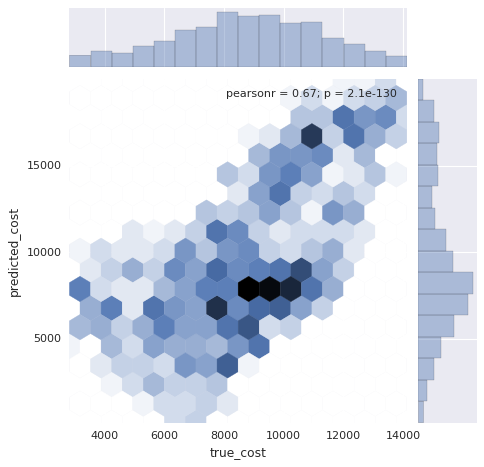

In [35]:
import seaborn as sns
sns.jointplot(x='true_cost', y="predicted_cost", data=df, kind='hex');

<h2> Cloud deploy model and predict </h2>

Now that we have a working model, we can turn the model loose and train on the full dataset. The model can then be deployed, which essentially puts it on the Cloud and attaches a REST API to it so that we can invoke the trained model from the windmills.

In [36]:
%bash
MODEL_NAME="windmill"
MODEL_VERSION="v3"
MODEL_LOCATION="/content/autoawesome/notebooks/ml_trained/model"
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
gcloud beta ml versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
gcloud beta ml models delete ${MODEL_NAME}
gcloud beta ml models create ${MODEL_NAME} --regions $REGION
gcloud beta ml versions create ${MODEL_VERSION} --model ${MODEL_NAME} --staging-bucket gs://${BUCKET} --origin ${MODEL_LOCATION}

Deleting and deploying autoawesome v1 from /content/autoawesome/notebooks/ml_trained/model ... this will take a few minutes


ERROR: (gcloud.beta.ml.versions.delete) NOT_FOUND: Field: name Error: The specified model version was not found.
Deleting model [autoawesome]...
done.
Creating version (this might take a few minutes)......
............................................................................................................................................................................................................................done.


After the model is deployed, we will want to test it.  An easy way to test a deployed ML model is to write out a file with some hypothetical inputs and then use gcloud to invoke the REST API.

<h2> Invoking REST API </h2>

Here is how the windmills invoke our model.  Note that invoking a deployed ML model is just a REST API call. The windmill owners don't know anything about what ML model we are running and this way, those details are all hidden away. The input variables may be scaled during preprocessing, but again the client doesn't know any of that.

<img src="serving_arch.png"/>

This preserves maximum flexbility.

In [ ]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

#import google.cloud.ml.features as features
#from google.cloud.ml import session_bundle

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1beta1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1beta1_discovery.json')

request_data = {'instances':
  [
     # redacted to protect privacy of our windmill owners
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'windmills', 'v3')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License